# Collab setup

In [1]:
import torch
def get_device():
    if torch.cuda.is_available():       
        device = torch.device("cuda")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
    else:
        device = torch.device("cpu")
        print('No GPU available, using the CPU instead.')

    return device

device = get_device()

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Copy and load the data

In [3]:
!ls

drive  sample_data


In [4]:
BASE_PATH = '/content/drive/MyDrive/ai/rsna-brain-tumor/'

In [5]:
!ls {BASE_PATH}

rsna-brain-tumor	   training_experiments.ipynb
rsna-brain-tumor-data.zip  train_labels.csv


In [6]:
file = BASE_PATH + 'rsna-brain-tumor-data.zip'

In [7]:
%%time
!cp {file} .

CPU times: user 1.62 s, sys: 311 ms, total: 1.93 s
Wall time: 4min 13s


In [8]:
!ls

drive  rsna-brain-tumor-data.zip  sample_data


In [9]:
%%time
!unzip ./rsna-brain-tumor-data.zip -d ./rsna-brain-tumor-data > /dev/null

CPU times: user 1.11 s, sys: 190 ms, total: 1.29 s
Wall time: 2min 39s


In [10]:
file = BASE_PATH + 'train_labels.csv'

In [11]:
%%time
!cp {file} .

CPU times: user 8.04 ms, sys: 7.44 ms, total: 15.5 ms
Wall time: 226 ms


# Imports

In [2]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [3]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
os.chdir("/content/drive/My Drive/ai/rsna-brain-tumor/rsna-brain-tumor/")
# os.chdir("/content/")

In [5]:
from train import train_num_iter
from utils import get_device, seed_everything, display_memory

from plot_utils import show_trainig_results
from plot_utils import show_loss
from plot_utils import show_image_3d

from dataset import Image3DDataset

from model_simple import Simple3DNet
from resnet import ResNet3D

In [6]:
seed = 2021
seed_everything(seed)

# Git repo

In [114]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   dataset.py
	modified:   main.py
	modified:   rsna-brain-tumor-train.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [115]:
# !git diff scripts/run_new_version.sh

In [118]:
!git add .

In [117]:
!git config --global user.email "michael.kalinin.nn@gmail.com"
!git config --global user.name "michaelka"

In [119]:
!git commit -m "[colab] Take slices with interval"

[master 846fadd] [colab] Take slices with interval
 3 files changed, 14 insertions(+), 3512 deletions(-)
 rewrite rsna-brain-tumor-train.ipynb (66%)


In [120]:
!git push origin master

Counting objects: 5, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 2.26 MiB | 3.34 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/MIchaelKa/rsna-brain-tumor.git
   02add8d..846fadd  master -> master


# Setup dataset

In [17]:
IMG_SIZE = 256

# TODO add isCollab check
# PATH_TO_DATA = './data/'
PATH_TO_DATA = '/content/'

IMG_PATH_TRAIN = os.path.join(PATH_TO_DATA, 'rsna-brain-tumor-data', 'train')
IMG_PATH_TEST = os.path.join(PATH_TO_DATA, 'rsna-brain-tumor-data', 'test')

In [18]:
train_labels_df = pd.read_csv(PATH_TO_DATA + 'train_labels.csv')
train_labels_df.shape

(585, 2)

In [19]:
print(train_labels_df.shape)
train_labels_df = train_labels_df.drop(train_labels_df[train_labels_df['BraTS21ID'] == 109].index)
train_labels_df = train_labels_df.drop(train_labels_df[train_labels_df['BraTS21ID'] == 709].index)
train_labels_df = train_labels_df.drop(train_labels_df[train_labels_df['BraTS21ID'] == 123].index)
print(train_labels_df.shape)

(585, 2)
(582, 2)


In [20]:
def row_to_mri_type_count(row, mri_type):
    case_id = row['BraTS21ID']
    case_id = f'{case_id:0>5d}'
    images_path = os.path.join(IMG_PATH_TRAIN, case_id, mri_type)
    try: 
        count = len(os.listdir(images_path))
    except:
        return 0
       
    return count

In [21]:
MRI_TYPES = ['FLAIR', 'T1w', 'T1wCE', 'T2w']

def get_mri_count():
    for mri_type in MRI_TYPES:
        train_labels_df[f'{mri_type}_count'] = train_labels_df.apply(
            lambda row: row_to_mri_type_count(row, mri_type),
            axis=1
        )
        
get_mri_count()

In [22]:
from torchvision import transforms as T

def get_train_transform(img_size):
    transform = T.Compose([
        T.Resize((img_size, img_size)),
#         T.ToTensor(),
        # T.Normalize(mean=[0.485, 0.456, 0.406],
        #             std=[0.229, 0.224, 0.225])
    ])
    return transform

In [33]:
MRI_TYPES = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
# MRI_TYPES = ['FLAIR', 'T2w']

train_dataset = Image3DDataset(
    train_labels_df,
    IMG_PATH_TRAIN,
    mri_types=MRI_TYPES,
    reduce_mode=0,
    max_depth=32,
    zero_pad=True,
    reflective_pad=False,
    transform=get_train_transform(IMG_SIZE)
)

len(train_dataset)

582

In [34]:
image, label = train_dataset[2] # 391
type(image), image.shape, label

(numpy.ndarray, (1, 128, 256, 256), 0)

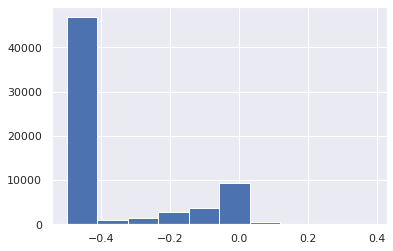

In [35]:
plt.hist(image[0, 40].reshape(-1))
plt.show()

shape: (128, 256, 256)


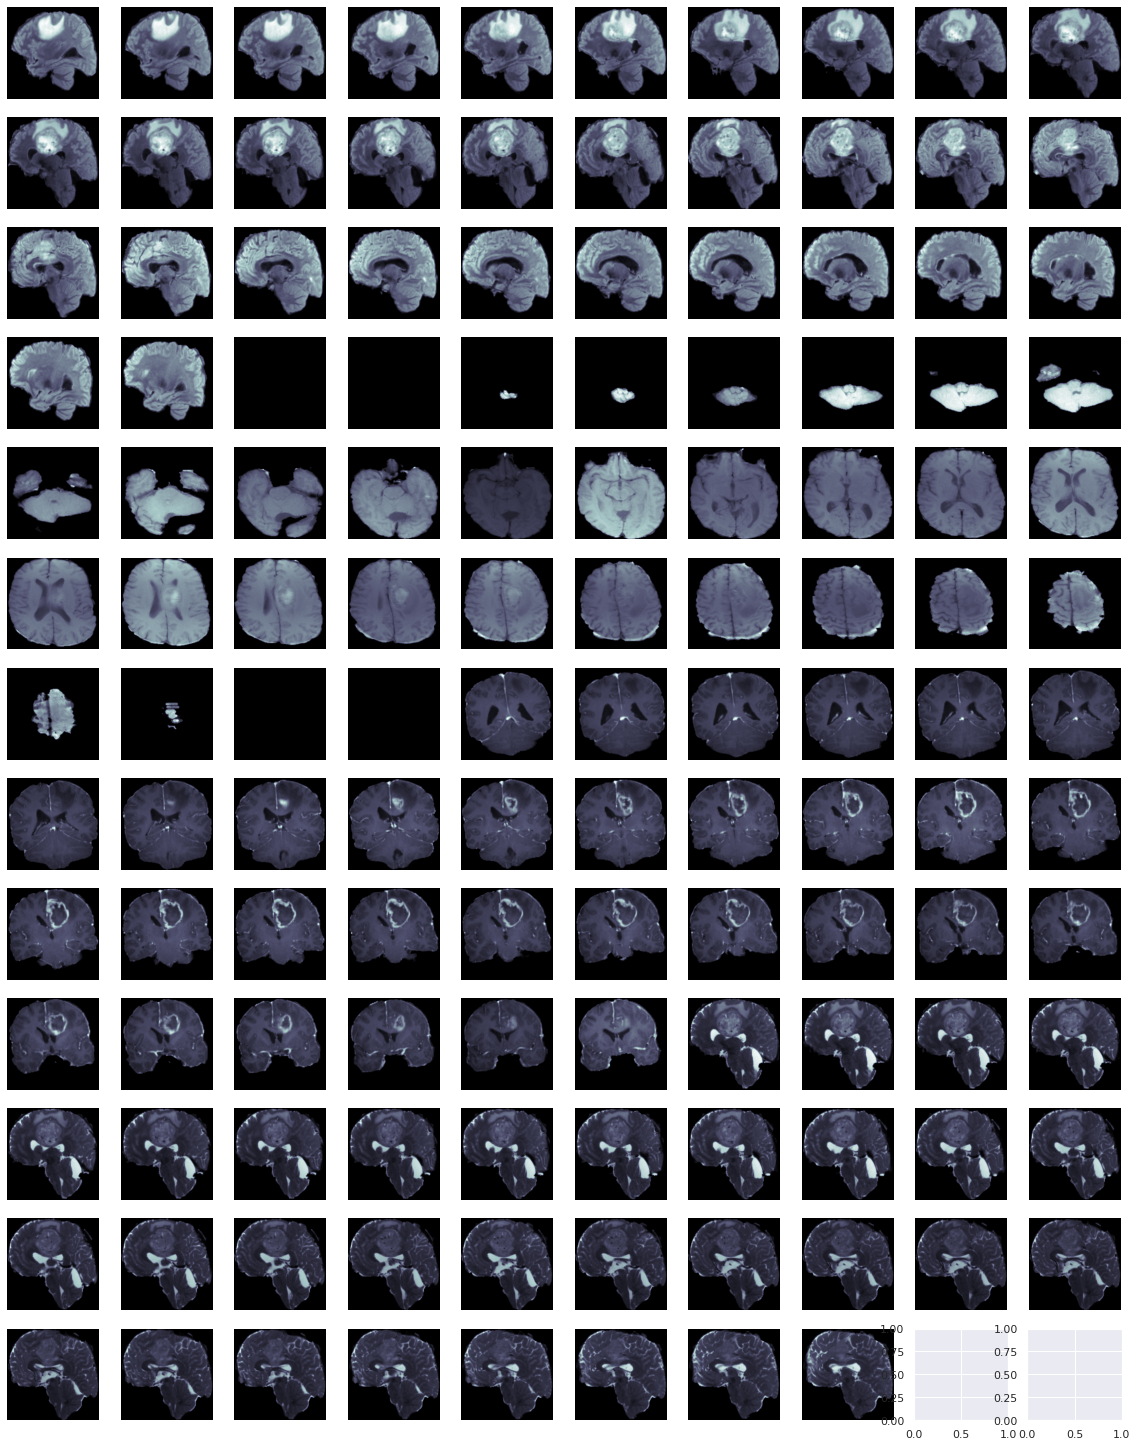

In [36]:
show_image_3d(image)

shape: (64, 256, 256)


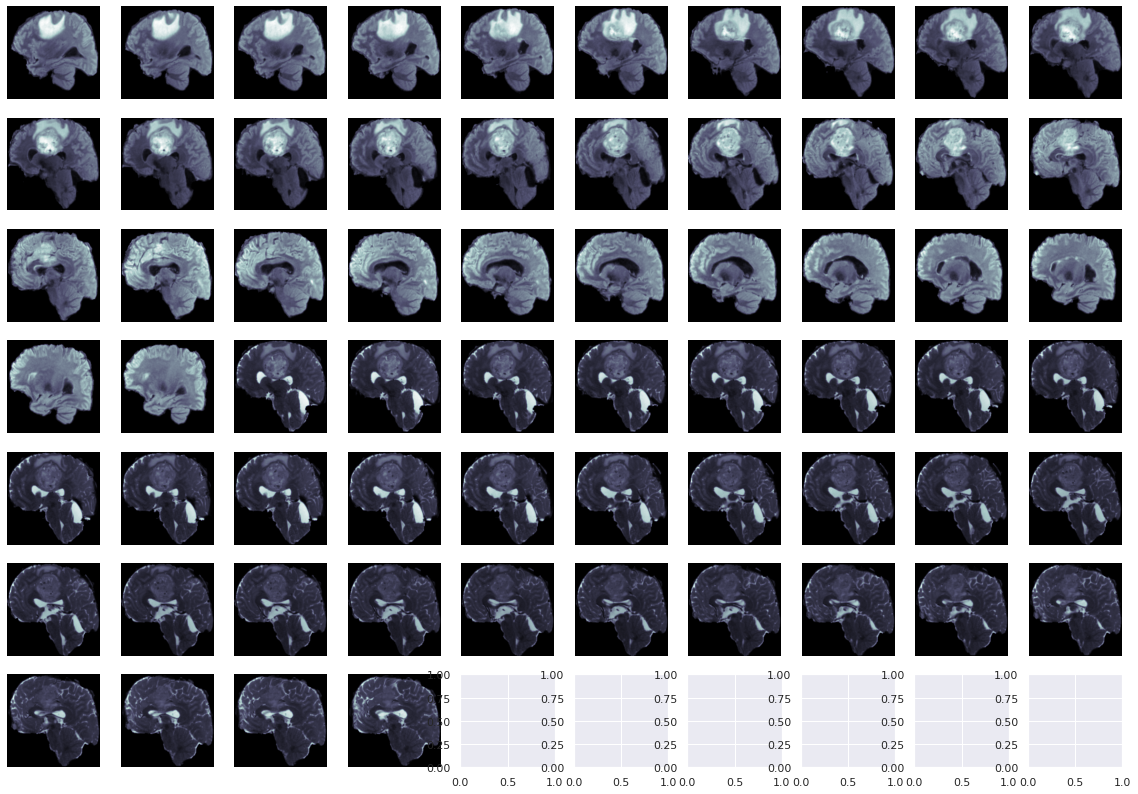

In [51]:
show_image_3d(image)

In [27]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
len(train_loader)

146

In [ ]:
train_loader_iter = iter(train_loader)

In [ ]:
x_batch, y_batch = next(train_loader_iter)
x_batch.shape, y_batch.shape

(torch.Size([4, 1, 64, 256, 256]), torch.Size([4]))

In [ ]:
x_batch.dtype, y_batch.dtype

(torch.float64, torch.int64)

In [ ]:
x_batch = x_batch.type(torch.float32)

In [ ]:
# y_batch = y_batch.long()
# y_batch = y_batch.type(torch.LongTensor)

In [ ]:
y_batch, y_batch.dtype

(tensor([1, 1, 1, 0]), torch.int64)

## IterableDataset

In [ ]:
max_depth=256

train_dataset = Image3DDataset(
    train_labels_df,
    IMG_PATH_TRAIN,
    max_depth=max_depth,
    zero_pad=False,
    reflective_pad=False,
    transform=get_train_transform(IMG_SIZE)
)

len(train_dataset)

582

In [ ]:
image, label = train_dataset[391] # 391

shape: (14, 256, 256)


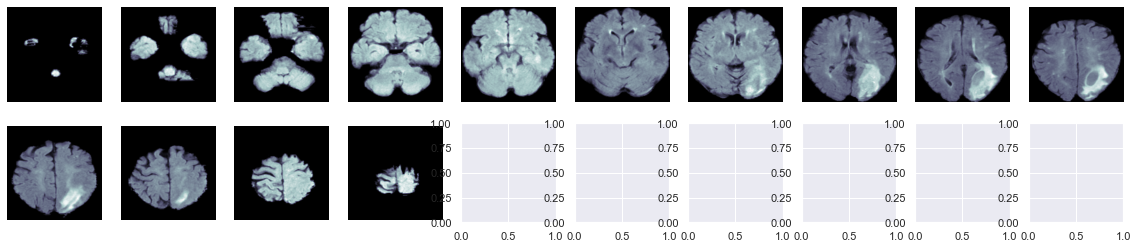

In [ ]:
show_image_3d(image)

In [ ]:
data_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
len(data_loader)

582

In [ ]:
data_loader_iter = iter(data_loader)

In [ ]:
x_batch, y_batch = next(data_loader_iter)
x_batch.shape, y_batch.shape

(torch.Size([1, 1, 256, 256, 256]), torch.Size([1]))

In [ ]:
# show_image_3d(x_batch[0])

In [ ]:
from dataset import DepthGroupedDataset

In [ ]:
grouped_dataset = DepthGroupedDataset(data_loader, batch_size=4, max_depth=max_depth)

In [ ]:
grouped_dataset_iter = iter(grouped_dataset)

In [ ]:
x, y = next(grouped_dataset_iter)

del bucket 3
49 torch.Size([1, 1, 49, 256, 256]) 1
46 torch.Size([1, 1, 46, 256, 256]) 1
49 torch.Size([1, 1, 49, 256, 256]) 1
256 torch.Size([1, 1, 256, 256, 256]) 3
30 torch.Size([1, 1, 30, 256, 256]) 0
256 torch.Size([1, 1, 256, 256, 256]) 3
140 torch.Size([1, 1, 140, 256, 256]) 3
256 torch.Size([1, 1, 256, 256, 256]) 3
process_images
torch.Size([1, 1, 256, 256, 256])
torch.Size([1, 1, 256, 256, 256])
torch.Size([1, 1, 140, 256, 256])
torch.Size([1, 1, 256, 256, 256])


In [ ]:
for b in grouped_dataset._buckets:
    print(len(b))

2
3
0
4


In [ ]:
x.shape, y.shape

(torch.Size([4, 1, 256, 256, 256]), torch.Size([4, 1]))

shape: torch.Size([49, 256, 256])


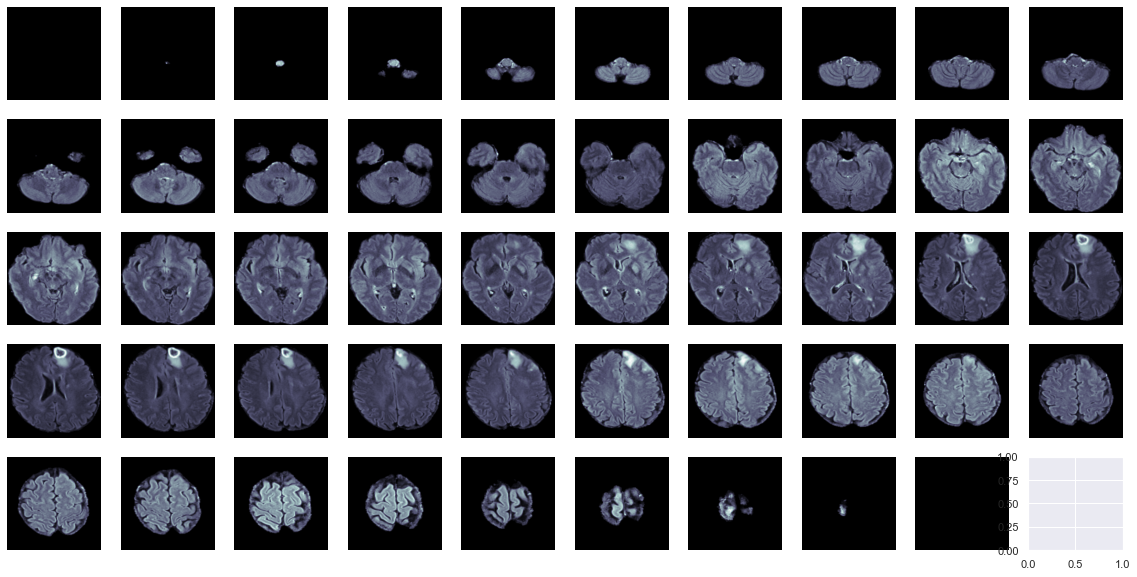

In [ ]:
show_image_3d(x[1])

# Profiling

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

In [ ]:
from utils import get_num_of_params

In [ ]:
model = Simple3DNet().to(device)
print(get_num_of_params(model))
model = ResNet3D().to(device)
print(get_num_of_params(model))

1370241
8231233


In [ ]:
N, C, D, H, W = 5, 1, 32, 32, 32
X = torch.randn(N, C, D, H, W)

In [ ]:
model = Simple3DNet()

In [ ]:
get_num_of_params(model)

1107905

In [ ]:
torch.__version__

'1.9.0+cu102'

In [ ]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(X)

In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference         1.18%       2.844ms        99.98%     241.917ms     241.917ms             1  
                     aten::conv3d         0.02%      37.000us        64.56%     156.219ms      52.073ms             3  
                aten::convolution         0.01%      34.000us        64.55%     156.182ms      52.061ms             3  
               aten::_convolution         0.03%      68.000us        64.54%     156.148ms      52.049ms             3  
         aten::mkldnn_convolution        64.35%     155.709ms        64.51%     156.080ms      52.027ms             3  
                 aten::max_pool3d       

In [ ]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls                                                                      Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                  model_inference         3.03%      13.457ms        99.99%     443.455ms     443.455ms             1                                                                                []  
                     aten::conv3d         0.01%      25.000us        39.04%     173.136ms     173.136ms             1                        [[5, 1, 32, 32, 32], [64, 1, 3, 3, 3], [], [], [], 

In [ ]:
# model = Simple3DNet().to(device)
# X = torch.randn(N, C, D, H, W).to(device)

model = Simple3DNet()
X = torch.randn(N, C, D, H, W)

In [ ]:
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    profile_memory=True,
    record_shapes=True
) as prof:
    with record_function("model_inference"):
        model(X)

In [ ]:
# cpu_memory_usage

# cuda_time_total

print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  aten::clamp_min         5.34%      12.196ms        10.67%      24.356ms       4.059ms     105.00 Mb      52.50 Mb             6  
                      aten::empty         0.05%     116.000us         0.05%     116.000us       7.733us      52.50 Mb      52.50 Mb            15  
                     aten::conv3d         0.01%      29.000us        63.12%     144.145ms      48.048ms      52.50 Mb           0 b             3  
                aten::convolution         0.01%      32.000us        63.11%     144.116ms      48.039ms      52.

# Memory management

In [7]:
# del X
display_memory(device)
X = torch.randn(8, 1, 128, 256, 256).to(device)
display_memory(device) # 256*256*256*4 / 1024 ** 3

0.000 GB
0.250 GB


In [8]:
%%time

display_memory(device)

# model = Simple3DNet().to(device)
model = ResNet3D().to(device)

output = model(X)
print(output.shape)

display_memory(device)
del output
display_memory(device)

0.250 GB
torch.Size([8, 1])
7.282 GB
0.282 GB
CPU times: user 155 ms, sys: 550 ms, total: 704 ms
Wall time: 7.73 s


In [9]:
model

ResNet3D(
  (stem): Sequential(
    (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
  )
  (layer2): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv3d(64, 512, kernel_size=(3, 3, 3

In [72]:
# del X
# del output
# del model
display_memory(device)

8.305 GB


In [ ]:
# when we can do this during training?
# we do not need actually?
# del output

# Single model path

In [ ]:
model = Simple3DNet()

In [ ]:
%%time
N, C, D, H, W = 5, 1, 26, 256, 256
X = torch.randn(N, C, D, H, W)

output = model(X)
output.shape

CPU times: user 30.1 s, sys: 5.37 s, total: 35.5 s
Wall time: 34.9 s


torch.Size([5, 1])

In [ ]:
# del output

In [ ]:
%%time
output = model(x_batch)
output.shape

CPU times: user 21.5 s, sys: 1.84 s, total: 23.4 s
Wall time: 23.4 s


In [ ]:
output.shape

torch.Size([4, 1])

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# output.dtype, y_batch.dtype

In [ ]:
y_batch = y_batch.type_as(output)
loss = criterion(output.squeeze(1), y_batch)

In [ ]:
loss

tensor(0.6934, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [ ]:
output, y_batch

(tensor([[0.0432],
         [0.0432],
         [0.0433],
         [0.0432]], grad_fn=<AddmmBackward>), tensor([0., 1., 0., 1.]))

In [ ]:
output.shape, y_batch.shape

(torch.Size([4, 1]), torch.Size([4]))

In [ ]:
y_pred = (output.squeeze(1) > 0)
# y_pred = torch.sigmoid(output)
# y_pred = y_pred > 0.5
y_pred, y_pred.shape

(tensor([True, True, True, True]), torch.Size([4]))

In [ ]:
correct_samples = torch.sum(y_pred == y_batch)
correct_samples

tensor(2)

In [ ]:
y_batch.shape[0]

4

# Setup custom dataset

In [ ]:
display_memory()

0.069 GB


In [ ]:
train_number = 32

train_df_0 = train_labels_df[
    (train_labels_df['FLAIR_count'] < 75) &
    (train_labels_df['FLAIR_count'] > 60) &
    (train_labels_df['MGMT_value'] == 0)]

train_df_0 = train_df_0.sample(frac=1).head(train_number//2)

train_df_1 = train_labels_df[
    (train_labels_df['FLAIR_count'] < 75) &
    (train_labels_df['FLAIR_count'] > 60) &
    (train_labels_df['MGMT_value'] == 1)]

train_df_1 = train_df_1.sample(frac=1).head(train_number//2)

train_df = pd.concat([train_df_0, train_df_1]).sample(frac=1).reset_index(drop=True)

,BraTS21ID,MGMT_value,FLAIR_count,T1w_count,T1wCE_count,T2w_count
0,17,0,74,28,231,87
1,54,1,72,27,240,82
2,6,1,68,28,89,270
3,98,1,73,30,249,73
4,53,0,74,29,243,300


In [ ]:
train_number = 256
train_df = train_labels_df.sample(frac=1).head(train_number).reset_index(drop=True)

In [ ]:
print(train_df.shape)
train_df.head()

(256, 6)


,BraTS21ID,MGMT_value,FLAIR_count,T1w_count,T1wCE_count,T2w_count
0,496,0,113,147,147,270
1,657,0,146,146,146,283
2,71,1,140,29,96,287
3,96,1,74,30,90,293
4,837,0,47,141,141,47


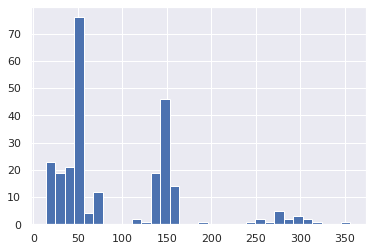

In [ ]:
train_df['FLAIR_count'].hist(bins=32)

# Run training

In [10]:
from main import run, main

In [11]:
# PATH_TO_DATA = './data/'
PATH_TO_DATA = '/content/'
PATH_TO_IMG = os.path.join(PATH_TO_DATA, 'rsna-brain-tumor-data')

In [12]:
3e-4

0.0003

In [ ]:
# TODO: move to main?

MRI_TYPES = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
# MRI_TYPES = ['FLAIR', 'T1w', 'T1wCE']

params = dict(
    path_to_data=PATH_TO_DATA,
    path_to_img=PATH_TO_IMG,
    reduce_train=False,
    train_number=0,
    valid_number=0,
    
    # max_depth=256,
    # depth_grouped=True,
    # reflective_pad=True,

    max_depth=32,
    depth_grouped=False,
    reflective_pad=False,
    mri_types=MRI_TYPES,
    reduce_mode=1, # 0 == middle, 1 == interval
    
    batch_size_train=8,
    batch_size_valid=8,
    # max_iter=400,
    # valid_iters = [1, 3, 5]
    
    optimizer_name='Adam', # Adam, SGD
    learning_rate=3e-4,
    weight_decay=0,
)

# 1.
# Debug (toy model?)
# params['batch_size_train'] = 2
# params['batch_size_valid'] = 2
# params['reduce_train'] = True
# params['train_number'] = 10
# params['valid_number'] = 10
# params['max_iter'] = 6
# params['valid_iters'] = [1, 3, 5]

# 2.
# Overfit small dataset
# params['batch_size_train'] = 8
# params['batch_size_valid'] = 8
params['reduce_train'] = True
params['train_number'] = 256 # 468
params['valid_number'] = 64
params['max_iter'] = 400

# TODO: always validate at params['max_iter']-1 ?
# valid_iters = [10, 50, 100, 150, params['max_iter']-1]
valid_iters = [10, 100, 200, 300, params['max_iter']-1]
params['valid_iters'] = valid_iters


# model = Simple3DNet().to(device)
model = ResNet3D().to(device)

train_info = run(model, device, **params)

[run]
[data] Dataset size: 585
[data] Removing bad data...
[data] Dataset size: 582
[data] Dataset size, train: 466, valid: 116
[data] Reduced dataset size, train: 256, valid: 64
[data] DataLoader size, train: 32, valid: 8
[train] started...
[train] iter:   10, loss = 0.75000, score = 0.47727, time: 0:03:59
[valid] iter:   10, loss = 1.29176, score = 0.43750, time: 0:03:59

[train] iter:  100, loss = 0.69394, score = 0.56188, time: 0:26:55
[valid] iter:  100, loss = 0.71229, score = 0.46875, time: 0:26:55



In [54]:
# x, y = next(iter(train_info))
# show_image_3d(x[0])

In [ ]:
print(model)

In [11]:
# train_info = main(PATH_TO_DATA, PATH_TO_IMG)

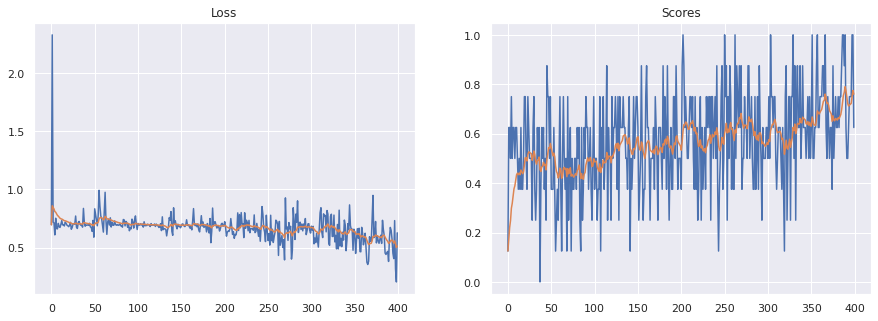

In [112]:
loss_meter = train_info['train_loss_meter']
score_meter = train_info['train_score_meter']
show_trainig_results(loss_meter, score_meter)

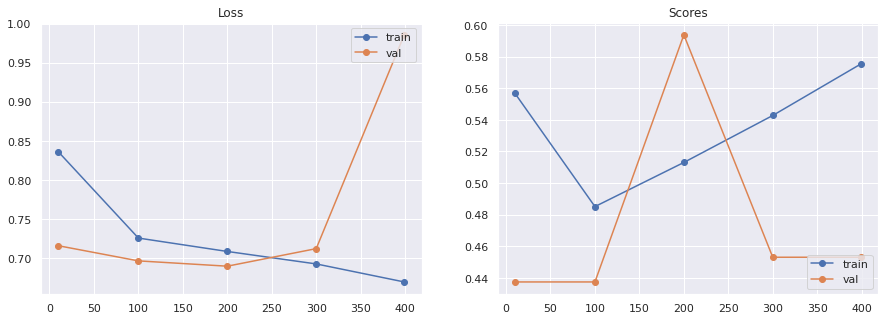

In [113]:
show_loss(train_info)

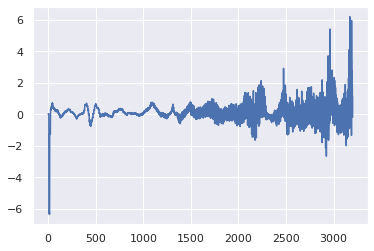

In [111]:
plt.plot(score_meter.get_outputs())

# Test validation

In [ ]:
from train import validate

In [ ]:
# TODO: Find the fastest valid_batch_size
# increase val batch size until we can?
# test separetly, see above section
loss_meter, score_meter = validate(model, device, valid_loader, criterion, print_every=5)

[valid] iter:    0, loss = 0.72866, score = 0.25000, time: 0:00:02
[valid] iter:    5, loss = 0.60942, score = 0.70833, time: 0:00:14
[valid] iter:   10, loss = 0.56438, score = 0.75000, time: 0:00:24


In [ ]:
score_meter.compute_score()

0.717948717948718